# Naive models

Implements 2 naive models:  
- NaiveLag
- NaiveRollingMean

In [1]:
import seaborn as sns
import pandas as pd

import utils.utils as utils
import utils.utils_features as utils_features
import utils.utils_preprocessing as utils_preprocessing
import utils.utils_plots as utils_plots
import utils.constants as constants
from utils.utils_models import NaiveRollingMean, NaiveLag

sns.set_theme(style="darkgrid")

In [2]:
df_kaggle = pd.read_csv(constants.file_path)
df_agg = utils.aggregate_df(df_kaggle)

df_agg = utils_preprocessing.preprocess_columns(df_agg, bottom_up=False)

# Generate features
df_agg = utils_features.features_time_related(df_agg)
df_agg = utils_features.features_lag(df=df_agg, col='inventory_units', lags=[13, 14, 15], group_column='product_number')
df_agg = utils_features.features_lag(df=df_agg, col='sales_units', lags=[13, 14, 15], group_column='product_number')
df_agg = utils_features.features_rolling(df=df_agg, col='inventory_units', window_sizes=[4, 8], group_column='product_number')
df_agg = utils_features.features_rolling(df=df_agg, col='sales_units', window_sizes=[4, 8], group_column='product_number')
df_agg = utils_features.create_periods_feature(df_agg, coll_agg='product_number', date_column='date', target_col='inventory_units')

df_agg = df_agg.rename(columns={'inventory_units': 'y'}).set_index('date').sort_index()

/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["first_nonzero_signal"] = df.groupby(coll_agg)["signal_above_zero"].cumsum() > 0
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["feature_periods"] = df.groupby(coll_agg).cumcount() + 1


### Validate the last 13*2 weeks

In [3]:
fc_model_rolling = NaiveRollingMean(hyperparameters={'window': 4}, bottom_up=False)
results_cv = fc_model_rolling.cross_validate(df_agg, n_splits=2)

Average RMSE from cross-validation: 85.0425


In [4]:
fc_model_rolling = NaiveRollingMean(hyperparameters={'window': 8}, bottom_up=False)
results_cv = fc_model_rolling.cross_validate(df_agg, n_splits=2)

Average RMSE from cross-validation: 80.5450


In [5]:
fc_model_lag = NaiveLag(hyperparameters={'lag': 13}, bottom_up=False)
results_cv = fc_model_lag.cross_validate(df_agg, n_splits=2)

Average RMSE from cross-validation: 89.8495


/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X.sort_index().groupby(self.col_group)[self.column].last().to_dict()
/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X.sort_index().groupby(self.col_group)[self.column].last().to_dict()


### Plot results for the last 13 weeks

In [6]:
X_train, X_test, y_train, y_test = utils.train_test_split(df_agg, forecasting_horizon=13, target_col="y")

In [7]:
df_preds_rolling = utils.predict_last_13_weeks(df_agg, fc_model_rolling, col_agg='product_number')
df_preds_lag = utils.predict_last_13_weeks(df_agg, fc_model_lag, col_agg='product_number')

df_final = df_kaggle.merge(df_preds_rolling.reset_index(), on=['date', 'product_number'], how='left')

/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X.sort_index().groupby(self.col_group)[self.column].last().to_dict()


In [8]:
temp = df_preds_lag.reset_index().merge(df_preds_rolling, on=['date', 'product_number'], suffixes=['_lag', '_rolling'])
df_final = df_agg.merge(temp, on=['date', 'product_number'], how='left')[['date', 'product_number', 'year_week', 'id', 'y', 'y_pred_lag', 'y_pred_rolling']]
vline_dates = [df_final['date'].max() - pd.DateOffset(weeks=13)]

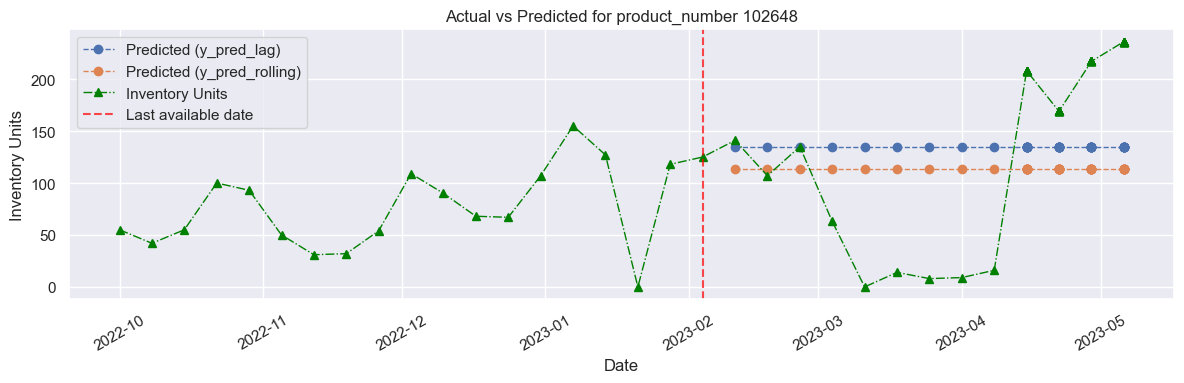

In [9]:
utils_plots.plot_real_vs_predicted(
    df_final.reset_index(), 
    single_ts=102648, 
    pred_columns=['y_pred_lag', 'y_pred_rolling'], 
    col_agg='product_number', 
    vline_dates=[constants.date_present]
    )